## Building a world immunization race with python!

importing necessary libraries

In [1]:
import os
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 50)
import geopandas as gpd
import numpy as np
import math

reading datasets/shapefiles for plotting

In [2]:
# data gathered on 19th of Feb, 2021
INFO_PATH = "../data/country_info.csv"  # https://www.kaggle.com/koryto/countryinfo?select=covid19countryinfo.csv
VACCINATION_PATH = "../data/country_vaccinations.csv"  # https://www.kaggle.com/gpreda/covid-world-vaccination-progress
SHAPEFILE_PATH = "../shapefiles/ne_10m_admin_0_countries_lakes/ne_10m_admin_0_countries_lakes.shp"  # https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_countries_lakes.zip

In [3]:
info_df = pd.read_csv(INFO_PATH, usecols=["country", "alpha3code", "pop"])
vac_df = pd.read_csv(VACCINATION_PATH, usecols=["country", "iso_code", "date", "total_vaccinations","daily_vaccinations"], parse_dates=["date"])
geo_df = gpd.read_file(SHAPEFILE_PATH)[['ADM0_A3', 'geometry']].to_crs('+proj=robin')

In [4]:
info_df = info_df[(~info_df['alpha3code'].isna()) & (~info_df['pop'].isna())]
info_df['pop'] = info_df['pop'].str.replace(",", "").astype(int)
vac_df = vac_df[~vac_df['iso_code'].isna()]
vac_df = vac_df[vac_df['iso_code'].isin(info_df['alpha3code'].tolist())]
vac_df.tail()

,country,iso_code,date,total_vaccinations,daily_vaccinations
3325,United States,USA,2021-02-13,50641884.0,1657703.0
3326,United States,USA,2021-02-14,52884356.0,1667631.0
3327,United States,USA,2021-02-15,NaN,1662106.0
3328,United States,USA,2021-02-16,55220364.0,1716311.0
3329,United States,USA,2021-02-17,56281827.0,1644551.0


Creating a list of countries that we have information about their daily vaccinations and an empty list to store countries that have "trustable" enough data. Also, initializing dictionaries to store the "earliest" and "latest"datapoint for each country and the desired daily vaccinations value for future predictions

In [5]:
all_countries = vac_df[vac_df['daily_vaccinations'].isna() == False].country.unique().tolist()
good_confidence_countries = []
countries_daily_fforward = {}
countries_first_update = {}
countries_latest_update = {}

Looping over the countries, selecting the ones that will be on the analysis(in this case, countries that have at least 15 days of vaccination data informed) and populating dictionaries

In [6]:
for c in all_countries:
    first_non_nan_idx = vac_df[(vac_df['daily_vaccinations'].isna() == False) & (vac_df['country'] == c)].head(1).index.item()
    this_c_df = vac_df[(vac_df.index >= first_non_nan_idx) & (vac_df.country == c)]
    nans_after_first_nan = this_c_df.daily_vaccinations.isna().sum()
    days_with_info = this_c_df.daily_vaccinations.notna().sum()
    first_non_nan_update = this_c_df[this_c_df.daily_vaccinations.notna()]['date'].head(1).item()
    latest_non_nan_update = this_c_df[this_c_df.daily_vaccinations.notna()]['date'].tail(1).item()
    lastest_date = this_c_df['date'].tail(1).item()
    if days_with_info < 15:
        continue
    else:
        good_confidence_countries.append(c)
        all_time_mean = this_c_df[this_c_df.daily_vaccinations.notna()]['daily_vaccinations'].mean()
        recent_mean = this_c_df[this_c_df.daily_vaccinations.notna()]['daily_vaccinations'].tail(5).mean()
        selected_forward_daily_vac = math.floor(0.15 * all_time_mean + recent_mean * 0.85)
        countries_daily_fforward[c] = selected_forward_daily_vac
        countries_first_update[c] = first_non_nan_update
        countries_latest_update[c] = latest_non_nan_update

For the last step, I chose to use 15% of the all time average + 85% of the five latest informed datapoints average value for my prediction of the future average daily vaccinations("selected_forward_daily_vac" var). I decided to do that because it was very commom to see one of the two cases below, where a country daily vaccination number could slowly progress and then stagnate, or perhaps start in a high note(when they receive a bunch of vaccine doses and suddenly drop, stagnating. For that it would be best to not focus so much on their early vaccination weeks or days, as It cant say very much about the future

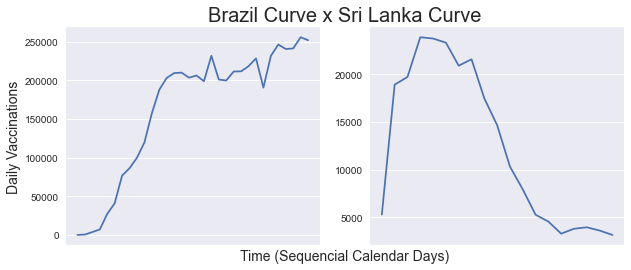

In [7]:
plt.style.use('seaborn')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
ax23 = fig.add_subplot(111, frameon = False)
ax23.set_xlabel('Time (Sequencial Calendar Days)', fontsize=14)
ax23.set_xticks([])
ax23.set_yticks([])
ax23.set_title("Brazil Curve x Sri Lanka Curve", fontsize=20)
axes[0].plot(vac_df[vac_df['country'] == "Brazil"].dropna().date, vac_df[vac_df['country'] == "Brazil"].dropna().daily_vaccinations)
axes[0].set_ylabel('Daily Vaccinations', fontsize=14)
axes[1].plot(vac_df[vac_df['country'] == "Sri Lanka"].dropna().date, vac_df[vac_df['country'] == "Sri Lanka"].dropna().daily_vaccinations)
for ax in axes:
    ax.set_xticklabels([])
    ax.set_xticks([])

plt.show()

keeping only desired countries

In [ ]:
vac_df = vac_df[vac_df['country'].isin(good_confidence_countries)]

Next, I will be creating a DataFrame where each row represents a {date,country} pair, with dates ranging from our first entry of daily vaccination until 2023. First I should know the starting date

In [8]:
vac_df[vac_df['date'] == vac_df[vac_df.daily_vaccinations.notna()]['date'].min()]

,country,iso_code,date,total_vaccinations,daily_vaccinations
3205,United Kingdom,GBR,2020-12-14,NaN,83940.0


Creating the DataFrame with the correct range of dates and country names, calling it "clean_df"

In [9]:
def create_country_date_df(countries, start, end):
    all_dfs = []
    for country in countries:
        df = pd.DataFrame({"date": pd.date_range(start, end), "country": country})
        all_dfs.append(df)
    concat_df = pd.concat(all_dfs, ignore_index=True)
    return concat_df
clean_df = create_country_date_df(good_confidence_countries, '2020-12-14', '2022-12-31')

Merging it with "vac_df" and "info_df", to get daily vaccination values(fixing iso_code column when it is NaN) and total needed vaccines by country(2 * population, since two doses are needed for each individual)

In [10]:
clean_df = pd.merge(left=clean_df, right=vac_df, how='left', on=['date','country'])
clean_df["iso_code"] = clean_df.groupby("country").transform(lambda x: x.fillna(method="bfill"))["iso_code"]
clean_df["iso_code"] = clean_df.groupby("country").transform(lambda x: x.fillna(method="ffill"))["iso_code"]
clean_df = clean_df.merge(info_df[["alpha3code", "pop"]], how="left", left_on="iso_code", right_on="alpha3code").drop(['alpha3code'], axis=1).rename({"pop":"needed_vaccines"}, axis=1)
clean_df['needed_vaccines'] = clean_df['needed_vaccines'].astype(np.int64) * 2 # converting from numpy.int32 to numpy.int64 to prevent overflow

filling in the "daily_vaccinations" column NaNs, using the already defined daily average when NaNs apper in the future(after the last datapoint of a country), zeros when it happens earlier than the first datapoint or simply fowardfilling when it happens between those dates

In [11]:
def correct_daily_vac_col(x):
    dt = x['date']
    country = x['country']
    before_first_info = dt < countries_first_update[country]
    after_last_info = dt > countries_latest_update[country]
    if before_first_info:
        return 0
    elif after_last_info:
        return countries_daily_fforward[country]
    elif pd.isnull(x['daily_vaccinations']):
        return x['daily_vaccinations']
    else:
        return math.floor(x['daily_vaccinations'])
clean_df['daily_vaccinations'] = clean_df.apply(lambda x: correct_daily_vac_col(x), axis=1)
clean_df['daily_vaccinations'] = clean_df['daily_vaccinations'].fillna(method="ffill")

Finding the % of the total population immunized on each date, for every country

In [12]:
clean_df["total_vaccinations"] = clean_df.groupby(['country'])['daily_vaccinations'].cumsum(axis=0)
clean_df["immunization_coverage"] = np.where((clean_df.total_vaccinations / clean_df.needed_vaccines) < 1, (clean_df.total_vaccinations / clean_df.needed_vaccines), 1)
clean_df['immunization_coverage'] = clean_df['immunization_coverage'] * 100  # transforming it to [0, 100] range

Merging it to the geopandas dataframe(rows of countries that are missing data will have NaNs)

In [13]:
merged = pd.merge(geo_df, clean_df, how='left', left_on='ADM0_A3', right_on='iso_code').drop(["iso_code"], axis=1)

iterating over each sequential date, building the leaderboard and plotting/saving the plots(in this case only three plots per month)

In [21]:
title = "      COVID-19 World Immunization Progress Until 2023"
description = "If vaccination across various countries remain in the same pace(as on February 19th, 2021), thats how the race goes.\n"\
"                   Data: Our World in Data - ourworldindata.org • Author: Gabriel Tardochi Salles".strip()
# set a variable that will call whatever column we want to visualise on the map
variable = 'immunization_coverage'
# set the range for the choropleth
vmin, vmax = 0, 100

completely_immunized = []
ranking = ''
# building and saving the ranking while creating the img files
for date in clean_df.date.unique():
    this_plot = merged[(merged['date'] == date) | (merged['date'].isna())]
    date_time = pd.to_datetime(str(date)) 
    date_string_to_plot = date_time.strftime("%b, %Y")
    date_string_to_save = date_time.strftime("%Y%m%d")
    month_year_only = date_time.strftime("%b/%Y")
    saving_path = f"../out/images/img_{date_string_to_save}.jpg"
    
    # checking if someone got 100%
    now_completed_countries = this_plot[(this_plot['immunization_coverage'] == 100) & ~(this_plot['country'].isin(completely_immunized))]['country'].tolist()
    for country in now_completed_countries:
        completely_immunized.append(country)
        podium_len = len(completely_immunized)
        suf = lambda n: "%d%s"%(n,{1:"st",2:"nd",3:"rd"}.get(n if n<20 else n%10,"th"))
        ranking += f"{suf(podium_len)} - {country} ({month_year_only})\n"
    if date_string_to_save == "20221231":
        ranking += "                . . ."
    if (not (date_string_to_save.endswith("05") or date_string_to_save.endswith("15") or date_string_to_save.endswith("25"))) or date_string_to_save == "20221231":
        continue
    # create figure and axes for Matplotlib
    fig, ax = plt.subplots(1, figsize=(14, 7))
    # plotting only countries that are "competing" on the race
    this_plot.dropna().plot(column=variable, cmap='Purples', linewidth=0.8, ax=ax, edgecolor='.9', vmin=vmin, vmax=vmax, legend=False, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    # remove the axis
    ax.axis('off')
    # add a title
    ax.set_title(title, fontdict={'fontsize': '24', 'fontweight' : '2'}, color='#0A0122')
    # create an annotation for the data source and author
    ax.annotate(description, xy=(0.1, .065), xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')
    # Create colorbar as a legend
    sm = plt.cm.ScalarMappable(cmap='Purples', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    # empty array for the data range
    sm._A = []
    # add the colorbar to the figure
    cbar = fig.colorbar(sm, label="% of the Population Fully Immunized", pad=0, shrink=0.7)
    # position the annotation of the date string to the bottom left
    ax.annotate(date_string_to_plot,
            xy=(0.14, .265), xycoords='figure fraction',
            horizontalalignment='center', verticalalignment='top',
            color='#3C4052', fontsize=20)
    
    # position the annotation of the ranking to the bottom left, above our date string
    ax.annotate(ranking,
            xy=(0.032, .57), xycoords='figure fraction', color='#717171',
            horizontalalignment='left', verticalalignment='top',
            fontsize=11)
    # plotting the rest of the countries differently
    this_plot[this_plot.isna().any(axis=1)].plot(ax=ax, color='#fafafa', hatch='///')
    fig.tight_layout(pad=0.05)
    # saving to our images directory
    plt.savefig(saving_path, dpi=300)
    # if its the last date available, save it many times to make the gif "pause" a little bit on the last image
    if date_string_to_save == "20221231":
        for i in range(10):
            plt.savefig(f"../out/images/img_{date_string_to_save + str(i)}.jpg", dpi=300)
    plt.close('all')

### Creating a GIF based on the Plots!

To achieve that I followed some steps:
* Install ImageMagick;
* Open up the terminal and navigate to the directory where the files were saved;
* Simply run the following command:<br>
"magick -delay 20 -loop 0 *.jpg immunization_race.gif"

![SegmentLocal](../out/immunization_race.gif "segment")